In [1]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate

In [4]:
def get_xy(df, col, row, x_col='all_data'):
    filtered = df[~df.iloc[:, col].isna()]
    return np.array(filtered[x_col])[:row], np.array(filtered.iloc[:, col])[:row]

def sigmoid(x, L ,x0, k, b):
    '''
    L is responsible for scaling the output range from [0,1] to [0,L]
    b adds bias to the output and changes its range from [0,L] to [b,L+b]
    k is responsible for scaling the input, which remains in (-inf,inf)
    x0 is the point in the middle of the Sigmoid, i.e. the point where Sigmoid
    should originally output the value 1/2 [since if x=x0, we get 1/(1+exp(0)) =
    1/2].
    '''
    return L / (1 + np.exp(-k*(x-x0))) + b

def sigmoid_tail(x, L, x0, k, b, x1, a1, a2):
    out = sigmoid(x, L, x0, k, b)
    tail = x[x > x1]
    out[x > x1] =  sigmoid(x1, L, x0, k, b) + a1 * (tail-x1) + a2 * (tail-x1)**2
    return out

def make_sigmoid_tail(L, x0, k, b, x1):
    def sigmoid_tail(x, a1, a2):
        out = sigmoid(x, L, x0, k, b)
        tail = x[x > x1]
        out[x > x1] = sigmoid(x[x > x1], L, x0, k, b) + a1 * (tail-x1) + a2 * (tail-x1)**2
        return out
    return sigmoid_tail

def get_rsquared(f, x, y, popt):
    residuals = y - f(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1 - (ss_res / ss_tot)

In [ ]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,11): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[15000,30000,30000,10000,10000,17000,18000,10000,10000,20000,13000][col-1]
            #wheatz cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixbd21.csv')

/state/partition1/slurm_tmp/27063669.0.0/ipykernel_1950457/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


0.9549140671573797
0.9587198452739756
0.9649298377286996
0.9417962150423372
0.979502227268769
0.9627089577875096
0.9401669550330004
0.9682955339920963
0.9572941185060285
0.9201797337076613
0.9434557182831291
0.9169247836265462
0.9349978578472619
0.9325910197867964
0.9626777174403328
0.9173877569970992
0.9404231993621596
0.9199297398376501


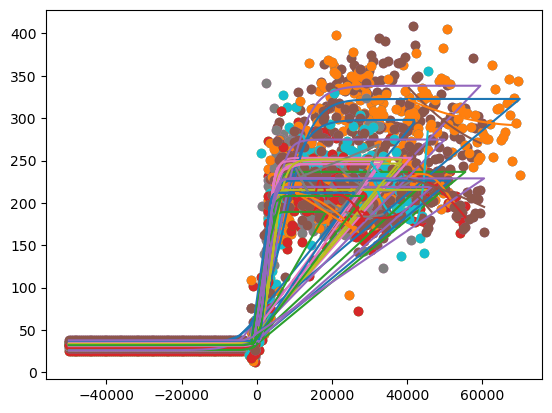

In [5]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,19): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[40000,40000,40000,20000,30000,40000,20000,40000,10000,40000,40000,15000,40000,10000,30000,10000,20000,40000,40000,40000,40000,40000,40000,40000,40000,40000][col-1] #bd21             #wheatz cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixoat_2.csv')

0.9276448206691756


/state/partition1/slurm_tmp/26244927.0.0/ipykernel_3921273/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


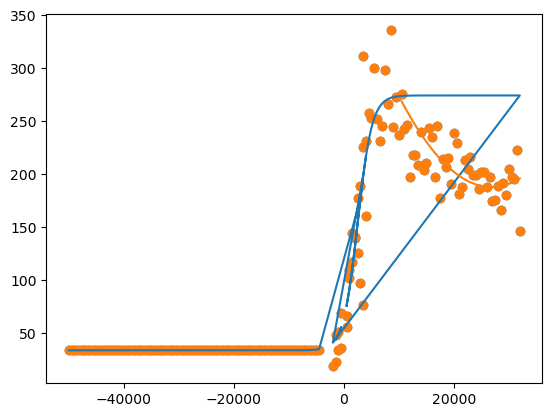

In [12]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(9,10): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[40000,40000,40000,20000,30000,40000,20000,40000,10000,40000,40000,15000,40000,10000,30000,10000,20000,40000,40000,40000,40000,40000,40000,40000,40000,40000][col-1] #bd21             #wheatz cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixoat.csv')

/state/partition1/slurm_tmp/26262497.0.0/ipykernel_3114971/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


0.9345733028550006
0.9671628811951516
0.8993180312316901
0.9537036917122065
0.9145537821934792
0.9475523009488527
0.8517423561295803
0.864215872482406
0.9120389979963928
0.9149938231746413
0.9405473493356732
0.7640041645205768
0.9510367190609849
0.9335571185849456
0.9394580798944866
0.9097680670472583
0.9537418454239781
0.9415012082618286
0.9578742844350595


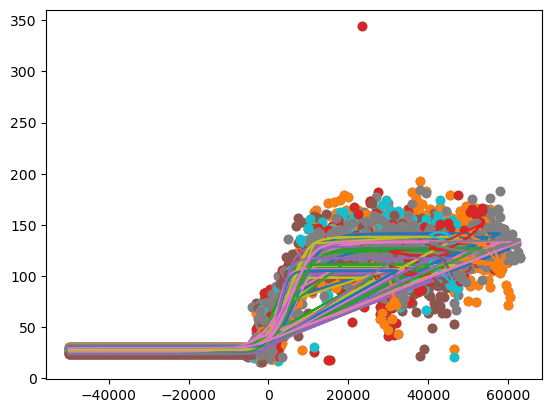

In [3]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,20): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[40000,30000,30000,40000,25000,50000,25000,40000,50000,40000,45000,30000,40000,30000,40000,30000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000][col-1] #bd21 
            #wheatz cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixbarley.csv')

/state/partition1/slurm_tmp/26257004.0.0/ipykernel_484677/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


0.9174600616874504
0.8804370251919656
0.9244240220643614
0.9069433491547392
0.9580877212201381
0.9128269841366358
0.8762484760256737
0.9098030453399788
0.9440989258137709


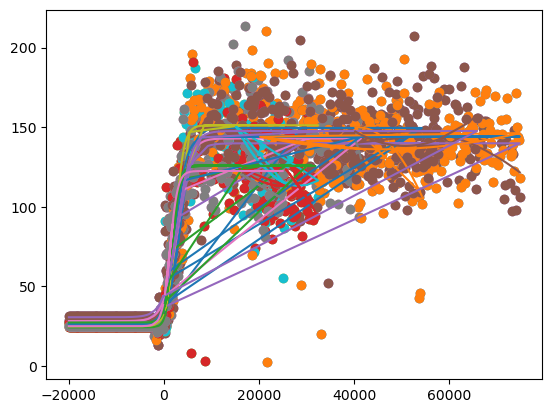

In [14]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,10): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[40000,15000,40000,40000,15000,20000,25000,40000,15000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000][col-1] #bd21 #wheatz cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixwheatcs.csv')

/state/partition1/slurm_tmp/26262497.0.0/ipykernel_3114971/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


0.8898779504174748
0.9164945192697008
0.898758713098621
0.9637969060591342
0.9242892194129928
0.9670481275970275
0.9400596351955994
0.9055506190682656


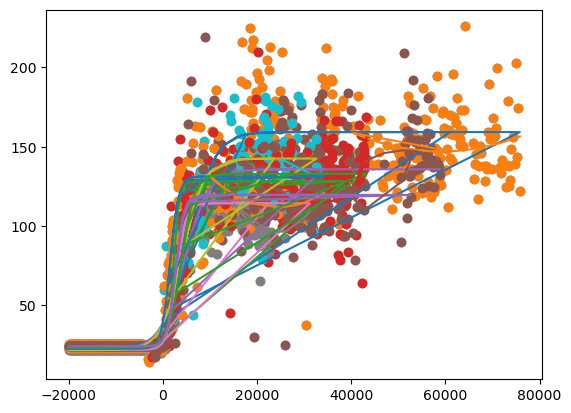

In [6]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,9): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[40000,20000,40000,15000,25000,10000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000][col-1] #bd21 
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixwheatL.csv')

/state/partition1/slurm_tmp/27037578.0.0/ipykernel_794599/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


0.9063616837993802
0.8751691338929928
0.8940126446654556
0.8704222588967937
0.8356995324965897
0.832256128993047
0.731652667821993
0.8853245667849481


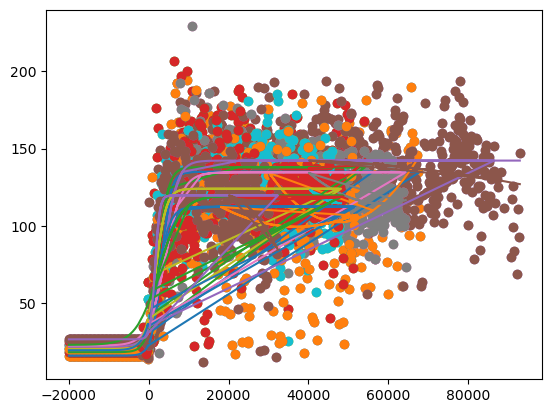

In [14]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for col in range(1,9): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 

            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff =[30000,40000,40000,40000,40000,18000,20000,20000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000][col-1] #bd21 
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixwheatzavitan.csv')

0.6119949485076409


/state/partition1/slurm_tmp/26202311.0.0/ipykernel_2925432/1825727839.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) + b


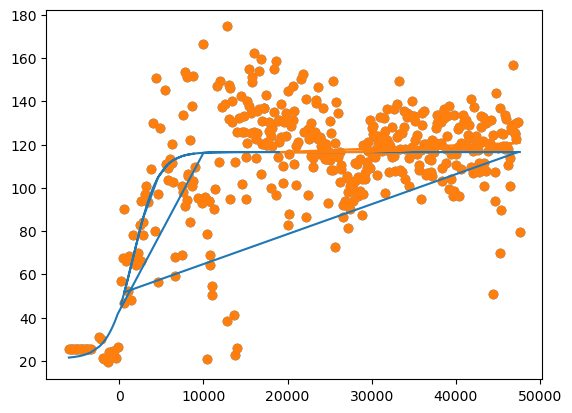

In [104]:
def save_csv(filename):
    df = pd.read_csv(filename)
    outfile = filename[:-4] + '_out.csv'
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['L', 'x0', 'k', 'b', 'lf', 'li', 'li2','Lge', 'N','der','L10','L90','r_squared'])
        for iii in range(1,2): #bd21
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
#        for col in range(1,19): 
            col=6
            x, y = get_xy(df, col, 250000, x_col='location')
            plt.scatter(x, y)
            # Find best guess using grid search
            Ls = np.linspace(0, 400, 10)
            x0s = np.linspace(0, 500, 10)
            ks = np.logspace(np.log10(0.001), np.log10(1), 10)
            bs = np.linspace(-10, 80, 10)
            grid = np.meshgrid(x, Ls, x0s, ks, bs, indexing='ij')
            yhat = sigmoid(*grid)

            # Mean-squared error
            mse = ((yhat - np.expand_dims(y, (1,2,3,4)))**2).mean(axis=0)
            idx = np.unravel_index(np.argmin(mse, axis=None), mse.shape)
            guess = [f[i] for f, i in zip((Ls, x0s, ks, bs), idx)]

            # Optimize guess using curve-fit 
            cutoff=[20000,25000,40000,25000,0,19000,30000,0,0,10000,][col-1]
            #wheatz cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatcs cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatl cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatbarley cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]
            #wheatoat cutoff=[20000,25000,40000,25000,0,40000,40000,0,0,10000,][col]            
            #cutoff=[40000,20000,25000,20000,20000,10000,40000,30000,30000,30000,25000,25000,25000][col]
            #cutoff=[40000,40000,30000,40000,20000,20000,20000,20000,40000,20000,40000,30000,30000,30000,30000,20000,40000,30000,40000][col]
            cut = ~(np.isnan(x) | np.isnan(y) | (x > cutoff))
            after_cut = ~(np.isnan(x) | np.isnan(y)| (x <= cutoff))
            popt, pcov = curve_fit(sigmoid, x[cut], y[cut], guess, method='lm')
            r_squared = get_rsquared(sigmoid, x[cut], y[cut], popt)
            print(r_squared)
            L, x0, k, b = popt

            sigmoid_tail = make_sigmoid_tail(*popt, cutoff)
            popt_tail, pcov_tail = curve_fit(sigmoid_tail, x[after_cut], y[after_cut], [0, 0], method='lm')
    
            plt.scatter(x, y)
            plt.plot(x, sigmoid(x, *popt))
            plt.plot(x[after_cut], sigmoid_tail(x[after_cut], *popt_tail))
            
            #Lge = -np.log(1/0.95-1)/k+x0
            Lge = -np.log(1/0.95-1)/k+x0
            L10 = -np.log(1/0.1-1)/k+x0
            L90 = -np.log(1/0.90-1)/k+x0
            #plt.axvline(x=Lge, c='r')
            lf = max(sigmoid(x, L, x0, k, b))
            li = (y[0]+y[1]+y[2])/3
            li2 = sigmoid(0, L, x0, k, b)
            N = integrate.quad(lambda x: 1/sigmoid(x, L, x0, k, b), 0, Lge)[0]
            #derivative
            der=k*L/4
            #(np.exp(-k*(x - x0))*k*L)/(1 + np.exp(-k*(x - x0)))**2
            writer.writerow([L, x0, k, b, lf, li, li2, Lge, N, der, L10, L90, r_squared])
save_csv('/home/gridsan/jyun/matrixwheatzavitan.csv')

### 